<a href="https://colab.research.google.com/github/gmazzitelli/studenti/blob/master/R_th.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
plt.style.use('fast')
plt.rc('font', size = 14, family ='Sans-Serif')
 
# download updated data
# repository italy https://github.com/pcm-dpc/COVID-19/tree/master/dati-andamento-nazionale
url_csv_file = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv"
df = pd.read_csv(url_csv_file)
# DATI COVID REGIONI
# istat http://dati.istat.it/Index.aspx?QueryId=26428#
url_csv_file = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv"
dr = pd.read_csv(url_csv_file)
Lombardia = dr.loc[(dr['denominazione_regione'] == 'Lombardia')].sort_values(by="data").copy()
Lazio = dr.loc[(dr['denominazione_regione'] == 'Lazio')].sort_values(by="data").copy()
Italia = df.copy() 
# DATI Popolazione Regioni
url_csv_file = "https://docs.google.com/spreadsheet/ccc?key=1qL5B_J6eV6bD9zicR0YsCIaUMU0BhTdSTrqC1UcDBI8&output=csv"
# agiunta terapie intensive https://www.quotidianosanita.it/studi-e-analisi/articolo.php?articolo_id=82888
# fonte agenas https://www.agenas.gov.it/covid19/web/index.php?r=site%2Findex
dpr = pd.read_csv(url_csv_file)
dpr
 
print('aggiornamento al '+str(np.array(df['data'])[-1])[0:10])
def Exp(x, p0, p1): # negative exponential
    import numpy as np
    return p0*np.exp(x/p1)
 
def Infected(t, I0, mu, R0): # negative exponential
    import numpy as np
# https://medium.com/data-for-science/epidemic-modeling-101-or-why-your-covid19-exponential-fits-are-wrong-97aa50c55f8
    return I0*np.exp(mu*(R0-1)*t)
 
# def Logistic(x, L, k, x0):
#     import numpy as np
#     return L / (1. + np.exp(-k * (x - x0)))
 
def Logistic(x, a, b, c):
    import numpy as np
# https://it.wikipedia.org/wiki/Equazione_logistica
    return a / (1. + b * np.exp(-c * x))
 
def Logistic4(x, a, b, c, d):
    import numpy as np
# https://it.wikipedia.org/wiki/Equazione_logistica
    return a / (1. + b * np.exp(-c * x)) + d
 
def dLogistic(x, a, b, c):
    import numpy as np
    return a*b*c*np.exp(c*x)/(b+np.exp(c*x))**2
 
def Gompertz(x, a, b, c):
    import numpy as np
# https://en.wikipedia.org/wiki/Gompertz_function
    return a * np.exp(-b * np.exp(-c * x))
 
def dGompertz(x, a, b, c):
  import numpy as np
# https://en.wikipedia.org/wiki/Gompertz_function
  return a*b*c * np.exp(-b * np.exp(-c * x))*np.exp(-c * x)
 
def Gauss3(x, a0, x0, s0):
    import numpy as np
    return a0 * np.exp(-(x - x0)**2 / (2 * s0**2))
 
def Line(x, m, q):
    import numpy as np
    return m*x + q
 
def ManSdtSubArr(arr, rescaled_avarege):
  import numpy as np
  if len(arr)>rescaled_avarege & rescaled_avarege>1:
    a_split     = np.array_split(arr, int(len(arr)/rescaled_avarege))
    a_split_avg = [np.mean(x) for x in a_split]
    a_split_err = [np.std(x) for x in a_split]
    x = np.linspace(0, len(a_split_avg)*rescaled_avarege, len(a_split_avg))
    return x, np.array(a_split_avg), np.array(a_split_err)
  else:
    x = np.linspace(0, len(arr)*rescaled_avarege, len(arr))
    return x, np.array(arr), np.sqrt(arr)
    
def fittalo(func, x, y, ax, p0, fmt='k'):
  from scipy.optimize import curve_fit
  from sklearn.metrics import r2_score
  popt, pcov = curve_fit(func,x, y, p0=p0)
  perr = np.sqrt(np.diag(pcov))
  r2=r2_score(y, func(x, *popt))
  xf = np.linspace(x.min(), x.max(), 100)
  ax.plot(xf, func(xf, *popt), fmt, label='a = {0:.2e}±{1:.2e}\nb = {2:.2e}±{3:.2e} \
  \nc = {4:.2e}±{5:.2e}\nr^2 = {6:.3f}'.format(popt[0], perr[0], popt[1], perr[1], popt[2], perr[2], r2))
  return ax, popt
 
def Rth(data, N=7, d=4):
  # https://www.facebook.com/DatiAnalisiCoronavirus/posts/142436764043174?__tn__=K-R
  # faq ISS https://www.iss.it/primo-piano/-/asset_publisher/o4oGR9qmvUz9/content/faq-sul-calcolo-del-rt
  y = np.convolve(data, np.ones((N,))/N, mode='valid')
  x = np.linspace(0, len(y), len(y))
  return x[d:] , y[d:]/y[:-d]

aggiornamento al 2021-01-16


In [2]:
dr.tail()

,data,stato,codice_regione,denominazione_regione,lat,long,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,deceduti,casi_da_sospetto_diagnostico,casi_da_screening,totale_casi,tamponi,casi_testati,note,ingressi_terapia_intensiva,note_test,note_casi
6883,2021-01-16T17:00:00,ITA,19,Sicilia,38.115697,13.362357,1406,212,1618,43834,45452,407,1954,70884,2954,NaN,NaN,119290,1393086,900666.0,NaN,16.0,NaN,NaN
6884,2021-01-16T17:00:00,ITA,9,Toscana,43.769231,11.255889,706,125,831,7808,8639,41,436,114850,3957,NaN,NaN,127446,2026960,1111228.0,NaN,8.0,NaN,NaN
6885,2021-01-16T17:00:00,ITA,10,Umbria,43.106758,12.388247,278,49,327,4276,4603,114,241,26858,689,NaN,NaN,32150,547494,266388.0,Si fa presente come uno dei ricoveri in terapi...,3.0,NaN,NaN
6886,2021-01-16T17:00:00,ITA,2,Valle d'Aosta,45.737503,7.320149,44,4,48,365,413,-3,20,6815,393,NaN,NaN,7621,66406,40331.0,NaN,1.0,NaN,NaN
6887,2021-01-16T17:00:00,ITA,5,Veneto,45.434905,12.338452,2317,338,2655,69716,72371,-2982,1929,216500,7932,NaN,NaN,296803,3621037,1281448.0,Nei valori riportati per le terapie intensive ...,30.0,NaN,NaN


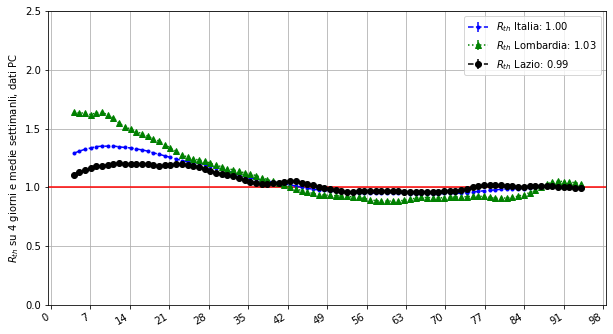

In [3]:
fig, ax = plt.subplots(figsize=(10,6))

what = 'nuovi_positivi'
what = 'ricoverati_con_sintomi' # faq ISS https://www.iss.it/primo-piano/-/asset_publisher/o4oGR9qmvUz9/content/faq-sul-calcolo-del-rt
data = df[what][-100:]
x , y = Rth(data)
ax.errorbar(x , y, yerr=0, fmt='b.--', label='$R_{th}$'+' Italia: {0:.2f}'.format(y[-1]))

data = Lombardia[what][-100:]
x , y = Rth(data)
ax.errorbar(x, y, yerr=0, fmt='g^:', label='$R_{th}$'+' Lombardia: {0:.2f}'.format(y[-1]))

data = Lazio[what][-100:]
x , y = Rth(data)
ax.errorbar(x , y, yerr=0, fmt='ko--', label='$R_{th}$'+' Lazio: {0:.2f}'.format(y[-1]))

ax.axhline(1, color='red')
ax.set_ylabel(r'$R_{th}$ su 4 giorni e medie settimanli, dati PC')
ax.xaxis.set_major_locator(MultipleLocator(7))

ax.set_ylim(0,2.5)
fig.autofmt_xdate()
ax.legend()
ax.grid()
plt.show()

In [4]:
Lazio

,data,stato,codice_regione,denominazione_regione,lat,long,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,deceduti,casi_da_sospetto_diagnostico,casi_da_screening,totale_casi,tamponi,casi_testati,note,ingressi_terapia_intensiva,note_test,note_casi
6,2020-02-24T18:00:00,ITA,12,Lazio,41.89277,12.483667,1,1,2,0,2,0,2,1,0,NaN,NaN,3,124,NaN,NaN,NaN,NaN,NaN
27,2020-02-25T18:00:00,ITA,12,Lazio,41.89277,12.483667,1,1,2,0,2,0,0,1,0,NaN,NaN,3,124,NaN,NaN,NaN,NaN,NaN
48,2020-02-26T18:00:00,ITA,12,Lazio,41.89277,12.483667,0,0,0,0,0,-2,0,3,0,NaN,NaN,3,124,NaN,NaN,NaN,NaN,NaN
69,2020-02-27T18:00:00,ITA,12,Lazio,41.89277,12.483667,0,0,0,0,0,0,0,3,0,NaN,NaN,3,552,NaN,NaN,NaN,NaN,NaN
90,2020-02-28T18:00:00,ITA,12,Lazio,41.89277,12.483667,0,0,0,0,0,0,0,3,0,NaN,NaN,3,611,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6789,2021-01-12T17:00:00,ITA,12,Lazio,41.89277,12.483667,2871,326,3197,75390,78587,-294,1381,99491,4218,NaN,NaN,182296,2853312,2110984.0,NaN,13.0,NaN,NaN
6810,2021-01-13T17:00:00,ITA,12,Lazio,41.89277,12.483667,2892,313,3205,75018,78223,-364,1612,101426,4259,NaN,NaN,183908,2866990,2117488.0,NaN,21.0,NaN,NaN
6831,2021-01-14T17:00:00,ITA,12,Lazio,41.89277,12.483667,2814,295,3109,74871,77980,-243,1816,103438,4306,NaN,NaN,185724,2880995,2124460.0,NaN,10.0,NaN,NaN
6852,2021-01-15T17:00:00,ITA,12,Lazio,41.89277,12.483667,2780,299,3079,74676,77755,-225,1394,105021,4342,NaN,NaN,187118,2909237,2140660.0,NaN,13.0,"Come da indicazioni, vengono inseriti solo i T...","Come da indicazioni, vengono inseriti solo i c..."


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:100: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in true_divide


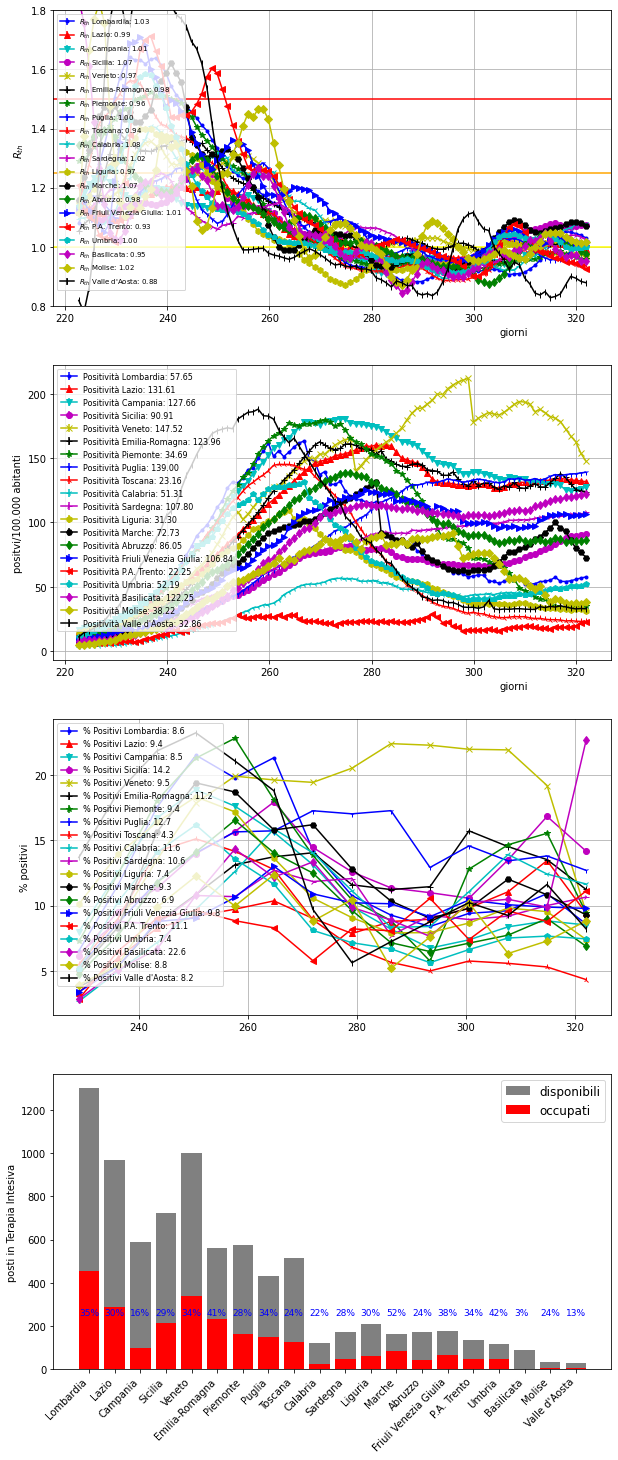

In [5]:
col    = ('b.-', 'r^-', 'cv-', 'mo-', 'yx-', 'k+-', 'g*-', 'b1-', 'r2-', 'c3-', 'm4-', 'yh-', 'kH-', 'gd-', 'b>-', 'r<-', 'cp-', 'md-', 'yD-', 'k|-', 'g,-')
regioni = np.array(dpr['Regione'])
ti = np.array(dpr['terapia_intensiva'])
tie = np.array(dpr['ti_esitenti'])
agenas = np.array(dpr['agenas'])
tir  = []
RthL = []
days = 100
people = np.array(dpr['Popolazione'])
fig, ax = plt.subplots((4), figsize=(10,25))
for r in range(0, len(regioni)):
  if regioni[r]=='Trentino Alto Adige':
    
    regioni[r] = 'P.A. Trento'
  drt = dr.loc[(dr['denominazione_regione'] == regioni[r])].sort_values(by="data").copy()
 
  data = np.array(drt['ricoverati_con_sintomi'])
  x , y = Rth(data)
  RthL.append(y[-1])
 
  ax[0].errorbar(x[-days:], y[-days:], yerr=0, fmt=col[r], label='$R_{th}$'+' {0:s}: {1:.2f}'.format(regioni[r],y[-1]))
  tir.append(np.array(drt['terapia_intensiva'])[-1])
  data2 = np.array(drt['totale_positivi'])/people[r]*10
  ax[1].errorbar(x[-days:], data2[-days:], yerr=0, fmt=col[r], label='Positività'+' {0:s}: {1:.2f}'.format(regioni[r],data2[-1]))
  data3 = np.array(drt['nuovi_positivi'])/np.gradient(drt['tamponi'])
  x, y, err = ManSdtSubArr(data3, 7)
  ax[2].errorbar(x[-np.int(days/7):], y[-np.int(days/7):]*100, yerr=0, fmt=col[r], label='% Positivi'+' {0:s}: {1:.1f}'.format(regioni[r],y[-1]*100))
 
ax[3].bar(regioni, agenas, width=0.8, color='gray', align='center', label='disponibili')
ax[3].bar(regioni, tir, width=0.8, color='r', align='center', label='occupati')
for i in range(regioni.size):
  plt.annotate('{:.0f}%'.format(100*tir[i]/agenas[i]), (i-0.4,250), fontsize=9, color='blue')
 
ax[0].legend(loc=2, prop={'size': 7})
ax[0].set_ylim(bottom=0.8, top=1.8)
ax[0].axhline(1.5, color='red')
ax[0].axhline(1.25, color='orange')
ax[0].axhline(1, color='yellow')
ax[0].grid()
ax[0].set_xlabel('giorni', horizontalalignment = 'left', x=0.8)
ax[1].set_xlabel('giorni', horizontalalignment = 'left', x=0.8)
ax[0].set_ylabel('$R_{th}$', horizontalalignment = 'left', x=0.8)
ax[1].set_ylabel('positvi/100.000 abitanti')
ax[1].legend(loc=2, prop={'size': 8})
ax[1].grid()
ax[2].set_ylabel('% positivi')
ax[2].legend(loc=2, prop={'size': 8})
ax[2].grid()
ax[3].set_ylabel('posti in Terapia Intesiva')
ax[3].legend(loc=0, prop={'size': 12})
plt.setp(ax[3].get_xticklabels(), rotation=45, ha='right')
plt.show()

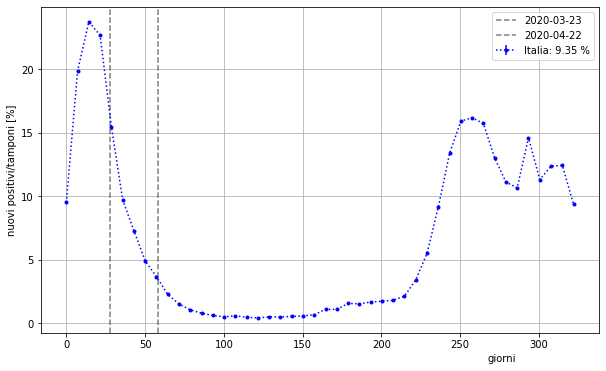

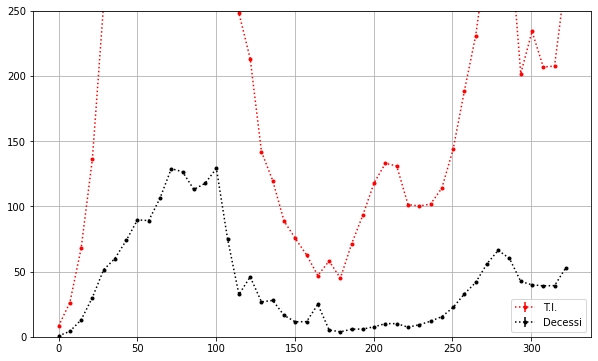

In [6]:
def tamp_perc(average_day=1):
  fig, ax = plt.subplots(figsize=(10,6))
  x = np.linspace(0, len(df['data']), len(df['data']))
  a = df['nuovi_positivi']
  b = np.gradient(df['tamponi'])
  c = a/b
 
  x, y, err = ManSdtSubArr(c, average_day)
 
  ax.errorbar(x,y*100, yerr=err, fmt='b:.', label = "Italia: {0:.2f} %".format(y[-1]*100))
  #GFPlot(y, ax, 4, 'b', label='casi', stat=True)
  ax.set_xlabel('giorni', horizontalalignment = 'left', x=0.8)
  ax.set_ylabel(r'nuovi positivi/tamponi [%]')
  day=28
  ax.axvline(day, color='black', linestyle='--', label='{:s}'.format(df.iloc[day, 0][0:10]), alpha=0.5)
  day=58
  ax.axvline(day, color='black', linestyle='--', label='{:s}'.format(df.iloc[day, 0][0:10]), alpha=0.5)
  #ax.set_ylim(0,1)
  ax.grid()
  plt.legend()
  plt.show()
  fig, ax = plt.subplots(figsize=(10,6))
  x_, y_, err = ManSdtSubArr(df['terapia_intensiva'], average_day)
  y_ = y_/(y*100)
  ax.errorbar(x_,y_, yerr=0, fmt='r:.', label = "T.I.")
  x_, y_, err = ManSdtSubArr(np.gradient(df['deceduti']), average_day)
  y_ = y_/(y*100)
  ax.errorbar(x_,y_, yerr=0, fmt='k:.', label = "Decessi")
  
  ax.set_ylim(0,250)
  ax.grid()
  plt.legend()
  plt.show()
tamp_perc(average_day=7)

Tsso POSITIVI [%]
[ 1.74725909e+00  2.03052378e+00  4.54612131e+00  6.71198063e+00
  8.15873658e+00  7.73049086e+00  5.75883275e+00  3.58273807e+00
  1.87832973e+00 -1.13314498e-01 -7.00391124e-01 -1.37937679e+00
 -1.40500665e+00 -9.56043202e-01 -1.17490053e-01 -6.27683440e-03
 -4.74950162e-01]
parametri fit gaussuano:  [1232.13046689   41.36197513   11.61355652]
2 sigma dal picco 76, oggi 119
Tsso OSPEDALIZZATI [%]
[ 1.98140359  2.14258139  4.44463638  6.54130543  7.40903923  6.50023368
  4.77870392  2.93339655  1.10919618 -0.41573778 -1.23500508 -1.16757614
 -1.46894041 -1.05912151 -0.23905129  0.19901158 -0.3716733 ]
Tsso TERAPIA INTENSIVA [%]
[ 2.06458444  2.53716043  4.34422838  8.36792942  6.76443489  6.77029684
  4.99750281  3.14899794  1.63492563 -0.08250516 -1.0684684  -1.32008944
 -2.01065891 -0.98985867 -0.02234762  0.15496154 -0.47036689]
Tsso DECEDUTI [%]
[ 0.00078666  0.00119388  0.00406081  0.01357311  0.02810807  0.03747886
  0.04454411  0.05792154  0.02315775 -0.000411

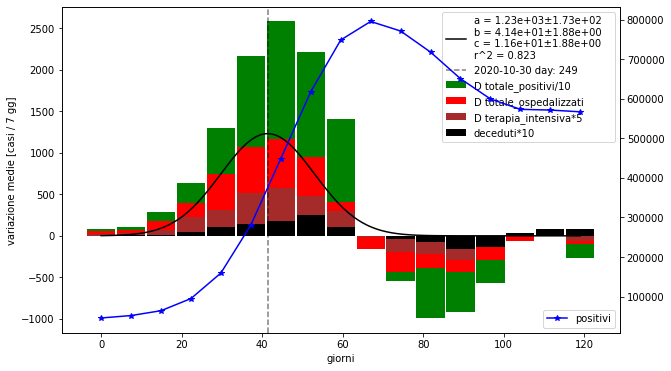

In [21]:
def do_av_plot(df=df, average_day = 7, day_start = 90):
  fig, ax = plt.subplots(figsize=(10,6))
  df_org = df.copy()
  d0 = day_start
  df = df.tail(day_start)
  day_start = day_start/average_day



  x, y, err = ManSdtSubArr(np.gradient(df['totale_positivi']), average_day)
  xt, yt, errt = ManSdtSubArr(df['totale_positivi'], average_day)

  ax.bar(x,y/10,color='green', width=average_day, label='D totale_positivi/10')
  print ("Tsso POSITIVI [%]")
  print (100*y/yt)

  x, y, err = ManSdtSubArr(np.gradient(df['totale_ospedalizzati']), average_day)
  xt, yt, errt = ManSdtSubArr(df['totale_ospedalizzati'], average_day)

  ax.bar(x,y,color='red', width=average_day, label='D totale_ospedalizzati')
  try:
    ax, par = fittalo(Gauss3,x,y, ax, [y.max(),x.mean(), x.std()], fmt='k')
    print ("parametri fit gaussuano: ", par)
    print ("2 sigma dal picco {:d}, oggi {:d}".format(int(par[1]+3*par[2]), int(x[-1])))
    print ("Tsso OSPEDALIZZATI [%]")
    print (100*y/yt)
    day=int(len(df_org)-d0+par[1])

    ax.axvline(par[1], color='black', linestyle='--', label='{:s} day: {:d}'.format(df_org.iloc[day, 0][0:10], day), alpha=0.5)
  except:
    print ("fit error...")
  x, y, err = ManSdtSubArr(np.gradient(df['terapia_intensiva']), average_day)
  xt, yt, errt = ManSdtSubArr(df['terapia_intensiva'], average_day)
  ax.bar(x,y*5,color='brown', width=average_day, label='D terapia_intensiva*5')
  print ("Tsso TERAPIA INTENSIVA [%]")
  print (100*y/yt)

  x, y, err = ManSdtSubArr(np.gradient(np.gradient(df['deceduti'])), average_day)
  xt, yt, errt = ManSdtSubArr(df['deceduti'], average_day)
  ax.bar(x,y*10,color='black', width=average_day, label='deceduti*10')
  print ("Tsso DECEDUTI [%]")
  print (100*y/yt)

  ax.set_xlabel('giorni')
  ax.set_ylabel('variazione medie [casi / {:d} gg]'.format(average_day))
  ax.legend()
  ax = ax.twinx()
  x = np.linspace(0, len(df['data']), len(df['data']))
  x, y, err = ManSdtSubArr(df['totale_positivi'], average_day)
  ax.plot(x,y, 'b*-', label='positivi')
  ax.legend(loc=4)
  
  plt.show()
do_av_plot(df=df, average_day = 7, day_start = 120)

Tsso POSITIVI [%]
[27.59687638 18.69766746 14.16836151  9.67185302  4.82925375  2.52702657
  1.45396745  0.37944714 -0.37269401 -1.40605338 -2.51833094 -3.20221567
 -2.95509119 -4.09962361]
parametri fit gaussuano:  [1579.08271948   19.65158409    8.74313262]
2 sigma dal picco 45, oggi 98
Tsso OSPEDALIZZATI [%]
[ 2.89811772e+01  2.01787752e+01  1.29646237e+01  6.96311192e+00
  3.02053747e+00  7.63678574e-03 -6.26141935e-01 -2.29685714e+00
 -3.06435046e+00 -2.91544753e+00 -3.69059939e+00 -3.63174423e+00
 -3.31634995e+00 -4.18367347e+00]
Tsso TERAPIA INTENSIVA [%]
[28.02547771 18.13160423 11.36663525  6.46005232  2.20497011 -1.02994572
 -2.54537868 -3.66443162 -4.05652704 -4.07699991 -5.84739264 -4.07520691
 -4.46559297 -3.54676711]
Tsso DECEDUTI [%]
[ 1.19505495e+01  7.29541367e+00  2.20735027e+00  7.80204088e-01
  1.00541488e-01 -1.76511955e-01 -2.76353024e-03 -6.33442041e-02
 -7.59647111e-02 -8.13016265e-03 -4.98945624e-02 -2.07271629e-02
 -2.81925309e-02 -1.79028572e-02]


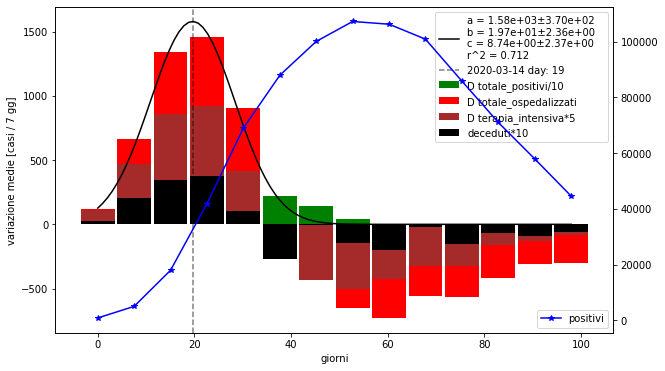

In [23]:
# prima ondata
do_av_plot(df=df.head(100), average_day = 7, day_start = 100)

Tsso POSITIVI [%]
[ 2.61447956  2.15860077  3.04936516  5.24593076  6.74567705  6.55704364
  5.14397095  3.9314984   2.8826717   1.41381415  0.6778132  -1.07216864
 -1.80230886 -0.05978055  0.08203717  0.30860505 -0.23567031]
parametri fit gaussuano:  [ 97.0703209   41.20692936 -12.62609433]
2 sigma dal picco 3, oggi 119
Tsso OSPEDALIZZATI [%]
[ 3.71929825  2.7149778   3.15105035  2.77167947  4.56678136  4.43302892
  3.98904636  2.28265817  0.9306471   0.36600401 -1.03246007 -0.65959756
 -0.92970115 -0.06388113  0.22522523  0.15134403 -0.34468683]
Tsso TERAPIA INTENSIVA [%]
[ 6.22406639  3.48101266  4.34173669  5.90682196  5.17836594  3.44530577
  3.62220718  2.05286839  2.95735901  0.71986837 -0.44354839 -0.2312868
 -1.47255689 -0.33800097  0.60776064  0.20737327 -1.71058715]
Tsso DECEDUTI [%]
[ 0.04173623  0.05830224  0.          0.03946613  0.0405954   0.11745796
 -0.02178649  0.09458054  0.01977379 -0.03821614  0.00578035  0.0349596
 -0.00920429 -0.02300293 -0.00774954  0.03417389 

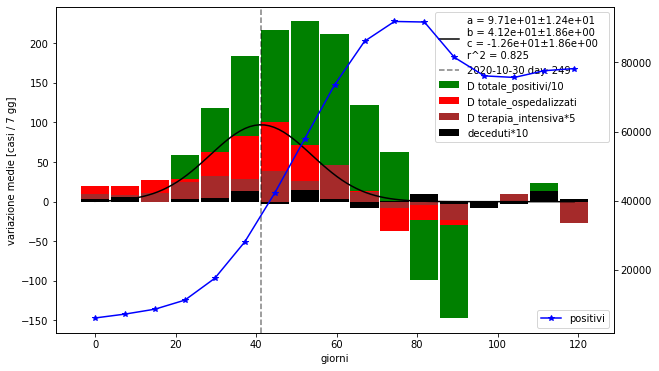

In [24]:
# Lazio
do_av_plot(df=Lazio, average_day = 7, day_start = 120)

Max 38 3940
Max 278 3746


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: overflow encountered in exp


Max 37 743
Max 280 726


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: overflow encountered in multiply


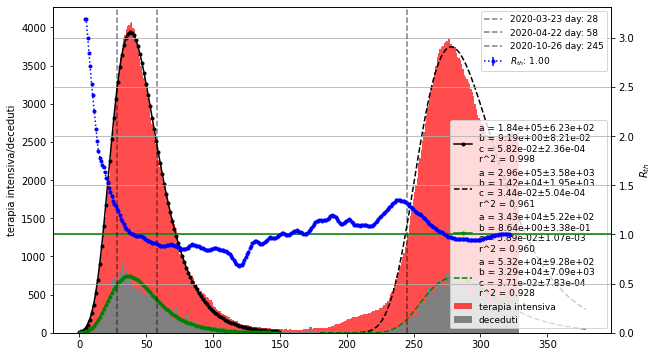

In [10]:
def predicGem(df=df, P_start=220, P_max = 285, slope=1):
  fig, ax = plt.subplots(figsize=(10,6))
  x = np.linspace(0, len(df['data']), len(df['data']))
  
  y = np.array(df['terapia_intensiva'])
  ax.bar(x,y, color='red', alpha=0.7, label='terapia intensiva', width=1)
  ax, par = fittalo(dGompertz, x[x<150], y[x<150], ax, [1e5,9., 0.1], 'k.-')
  print ("Max {0:.0f} {1:.0f}".format(np.log(par[1])/par[2], par[0]*par[2]/np.exp(1)))
  
  # Gompertz
  # a is the asymptote limit of grow
  # b sets the displacement along the x-axis 
  # c sets the growth rate (y scaling)
  c = par[2]*slope
  a = par[0]
  b = np.exp(P_max*c)

  xp = np.linspace(P_start, P_start+199, 200)

  yp = dGompertz(xp,*[a,b,c])

  for i in range(P_start, len(x)):
    yp[i-P_start]=y[i]

  
  ax, par = fittalo(dGompertz, xp, yp, ax, [a,b,c], 'k--')
  print ("Max {0:.0f} {1:.0f}".format(np.log(par[1])/par[2], par[0]*par[2]/np.exp(1)))

  
  y = np.gradient(df['deceduti'])

  ax.bar(x,y, color='gray', alpha=1, label='deceduti', width=1)
  ax, par = fittalo(dGompertz, x[x<150], y[x<150], ax, [3e4,8., 0.1], 'g.-')
  print ("Max {0:.0f} {1:.0f}".format(np.log(par[1])/par[2], par[0]*par[2]/np.exp(1)))
  
  c = par[2]*slope
  a = par[0]
  b = np.exp(P_max*c)

  xp = np.linspace(P_start, P_start+199, 200)

  yp = dGompertz(xp,*[a,b,c])
  for i in range(P_start, len(x)):

    yp[i-P_start]=y[i]

  
  ax, par = fittalo(dGompertz, xp, yp, ax, [a,b,c], 'g--')
  print ("Max {0:.0f} {1:.0f}".format(np.log(par[1])/par[2], par[0]*par[2]/np.exp(1)))
  
  
  ax.set_ylabel(r'terapia intensiva/deceduti')
  ax.set_ylim(bottom=0)
  ax.legend(loc=4, prop={'size': 9})
  ax = ax.twinx()
  
  # ricoverati_con_sintomi
  # nuovi_positivi
  data = df['ricoverati_con_sintomi']
  x_ , y_ = Rth(data)
  
  ax.errorbar(x_, y_, yerr=0, fmt='b.:', label='$R_{th}$'+': {0:.2f}'.format(y_[-1]))
  ax.axhline(1, color='green')
  ax.set_xlabel('giorni', horizontalalignment = 'left', x=0.8)
  ax.set_ylabel(r'$R_{th}$')
  day=28
  ax.axvline(day, color='black', linestyle='--', label='{:s} day: {:d}'.format(df.iloc[day, 0][0:10], day), alpha=0.5)
  day=58
  ax.axvline(day, color='black', linestyle='--', label='{:s} day: {:d}'.format(df.iloc[day, 0][0:10], day), alpha=0.5)
  day=245
  ax.axvline(day, color='black', linestyle='--', label='{:s} day: {:d}'.format(df.iloc[day, 0][0:10], day), alpha=0.5)
  
  ax.legend(loc=1, prop={'size': 9})
  ax.set_ylim(bottom=0)
  ax.grid()
  plt.show()
predicGem(df=Italia, P_start=180, P_max = 295, slope=0.9)

Max 37 1342
Max 278 872
Max 33 393


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: overflow encountered in multiply


Max 274 163


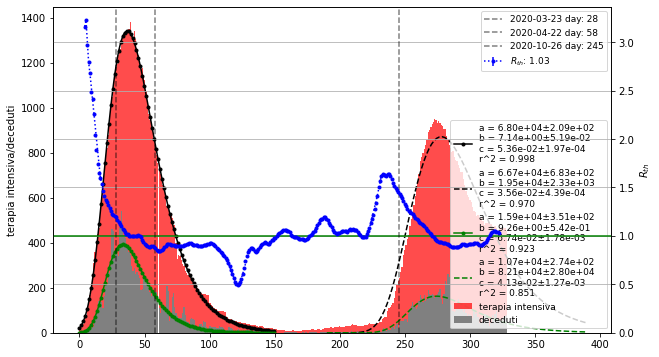

In [11]:
predicGem(df=Lombardia, P_start=190, P_max = 285, slope=0.7)

Max 48 196
Max 279 361


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: overflow encountered in multiply


Max 53 11
Max 281 50


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: overflow encountered in multiply


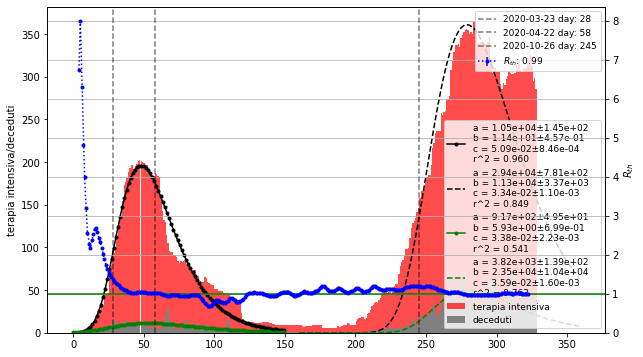

In [12]:
predicGem(df=Lazio, P_start=160, P_max = 300, slope=2.3)

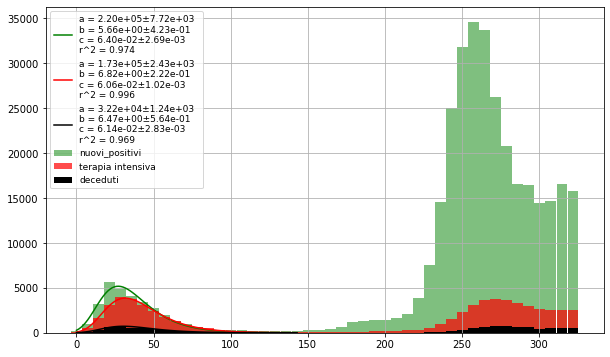

In [13]:
fig, ax = plt.subplots(figsize=(10,6))
average_day = 7
# y = df['totale_positivi']
# x, y, err = ManSdtSubArr(y, average_day)
# ax.plot(x,y, 'b.', alpha=0.5, label='totale_positivi') 

y = df['nuovi_positivi']
x, y, err = ManSdtSubArr(y, average_day)
ax.bar(x,y, color='green', alpha=0.5, label='nuovi_positivi', width=average_day) 
fittalo(dGompertz, x[x<150], y[x<150], ax, [4e6,7., 0.1], 'g')
y = df['terapia_intensiva']
x, y, err =  ManSdtSubArr(y, average_day)
ax.bar(x,y, color='red', alpha=0.7, label='terapia intensiva', width=average_day)
fittalo(dGompertz, x[x<150], y[x<150], ax, [1e5,9., 0.1], 'r')

y = np.gradient(df['deceduti'])
x, y, err =  ManSdtSubArr(y, average_day)
ax.bar(x,y, color='black', alpha=1, label='deceduti', width=average_day)
fittalo(dGompertz, x[x<150], y[x<150], ax, [3e4,8., 0.1], 'k')

ax.legend(loc=2, prop={'size': 9})
ax.grid()
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: overflow encountered in multiply


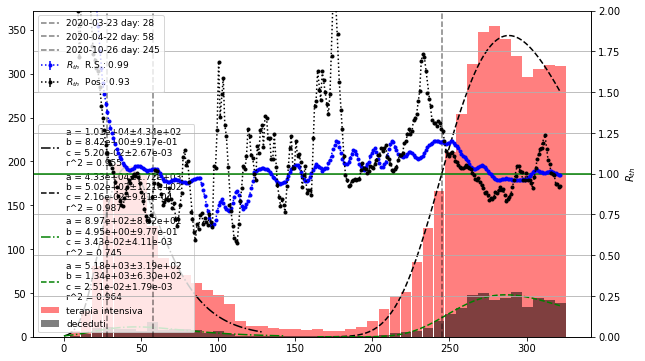

In [14]:
def do_av_fit(df=df, average_day = 7, P_start = 180, exp_peak = 275, RthN = 7, RthD = 4):
  fig, ax = plt.subplots(figsize=(10,6))


  y = np.array(df['terapia_intensiva'])
  x, y, err =  ManSdtSubArr(y, average_day)
  ax.bar(x,y, color='red', alpha=0.5, label='terapia intensiva', width=average_day)
  ax, par = fittalo(dGompertz, x[x<130], y[x<130], ax, [1e5,9., 0.1], 'k-.')

  # Gompertz
  # a is the asymptote limit of grow
  # b sets the displacement along the x-axis 
  # c sets the growth rate (y scaling)
  c = par[2]
  a = par[0]
  b = np.exp(exp_peak*c)
  try:
    ax, par = fittalo(dGompertz, x[x>P_start], y[x>P_start], ax, [a,b,c], 'k--')
  except:
    print ("unfittable")

  y = np.gradient(df['deceduti'])
  x, y, err =  ManSdtSubArr(y, average_day)
  ax.bar(x,y, color='black', alpha=0.5, label='deceduti', width=average_day)
  ax, par = fittalo(dGompertz, x[x<150], y[x<150], ax, [3e4,8., 0.1], 'g-.')

  # Gompertz
  # a is the asymptote limit of grow
  # b sets the displacement along the x-axis 
  # c sets the growth rate (y scaling)
  c = par[2]
  a = par[0]
  b = np.exp(exp_peak*c)
  try:
    ax, par = fittalo(dGompertz, x[x>P_start], y[x>P_start], ax, [a,b,c], 'g--')
  except:
    print ("unfittable")
  ax.legend(loc=3, prop={'size': 9})
  ax = ax.twinx()
  
  data = df['ricoverati_con_sintomi']
  x_ , y_ = Rth(data, RthN, RthD )
  
  # ax.errorbar(x, y, yerr=0, fmt='k.:', label='running avarege')
  ax.errorbar(x_, y_, yerr=0, fmt='b.:', label='$R_{th}$'+'  R.S.: {0:.2f}'.format(y_[-1]))
  data = df['nuovi_positivi']
  x_ , y_ = Rth(data, RthN, RthD )
  ax.errorbar(x_, y_, yerr=0, fmt='k.:', label='$R_{th}$'+'  Pos.: {0:.2f}'.format(y_[-1]))
  ax.axhline(1, color='green')
  ax.set_xlabel('giorni', horizontalalignment = 'left', x=0.8)
  ax.set_ylabel(r'$R_{th}$')
  day=28
  ax.axvline(day, color='black', linestyle='--', label='{:s} day: {:d}'.format(df.iloc[day, 0][0:10], day), alpha=0.5)
  day=58
  ax.axvline(day, color='black', linestyle='--', label='{:s} day: {:d}'.format(df.iloc[day, 0][0:10], day), alpha=0.5)
  day=245
  ax.axvline(day, color='black', linestyle='--', label='{:s} day: {:d}'.format(df.iloc[day, 0][0:10], day), alpha=0.5)
  
  ax.legend(loc=2, prop={'size': 9})
  ax.set_ylim(bottom=0, top=2)
  ax.grid()
  plt.show()
do_av_fit(df=Lazio, average_day = 7, P_start=160, exp_peak=290, RthN = 7, RthD = 4)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: overflow encountered in exp


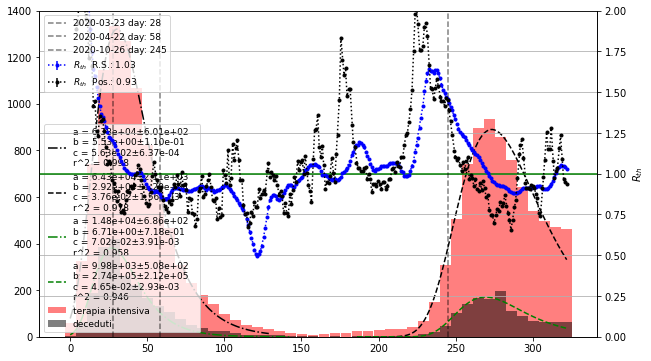

In [15]:
do_av_fit(df=Lombardia, average_day = 7, P_start=180, exp_peak=275, RthN = 7, RthD = 4)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: overflow encountered in multiply


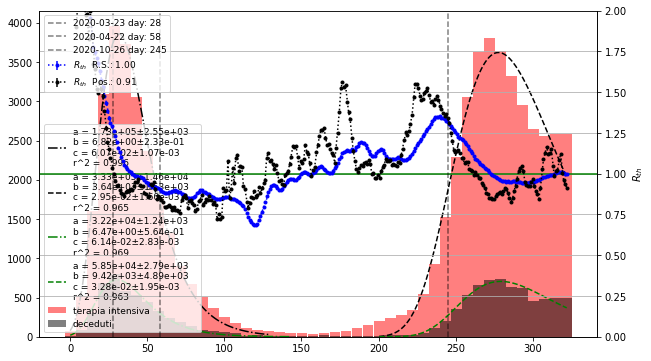

In [16]:
do_av_fit(df=Italia, average_day = 7, P_start=200, exp_peak=300, RthN = 7, RthD = 4)

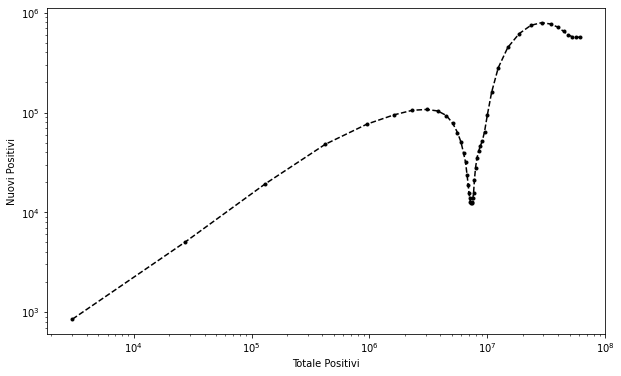

In [17]:
from scipy import integrate
fig, ax = plt.subplots(figsize=(10,6))
xi, yi, eri = ManSdtSubArr(integrate.cumtrapz(df['totale_positivi']),7)
xp, yp, eri = ManSdtSubArr(df['totale_positivi'],7)
ax.plot(yi,yp,'k.--')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Totale Positivi')
ax.set_ylabel('Nuovi Positivi')
plt.show()

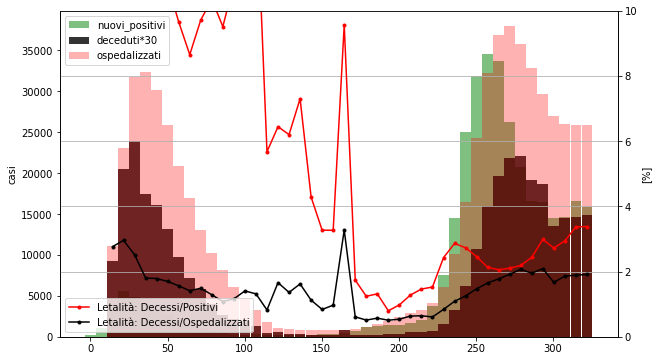

In [18]:
def letalita(df=df, average_day = 7, day_shift=14, day_start = 90):
  fig, ax = plt.subplots(figsize=(10,6))
  df_org = df.copy()
  d0 = day_start
  df = df.tail(day_start)
  day_start = day_start/average_day



  x, y, err    = ManSdtSubArr(df['nuovi_positivi'], average_day)
  xt, yt, errt = ManSdtSubArr(np.gradient(df['deceduti']), average_day)
  xo, yo, erro = ManSdtSubArr(df['totale_ospedalizzati'], average_day)

  ax.bar(x,y, color='green', alpha=0.5, label='nuovi_positivi', width=average_day) 
  week_shift = int(day_shift/average_day)
  if week_shift !=0:
    x=x[week_shift:]
    y=y[:-week_shift]
    xt=xt[:-week_shift]
    yt=yt[week_shift:]
    yo=yo[week_shift:]
  ax.bar(x,yt*30, color='black', alpha=0.8, label='deceduti*30', width=average_day)
  ax.bar(x,yo, color='red', alpha=0.3, label='ospedalizzati', width=average_day) 
  ax.set_ylabel('casi')
  ax.legend(loc=2)
  ax = ax.twinx()
  ax.plot(x,(yt/y)*100,'r.-', label='Letalità: Decessi/Positivi')
  ax.plot(x,(yt/yo)*100,'k.-', label='Letalità: Decessi/Ospedalizzati')

  ax.legend(loc=3)
  ax.set_ylim(0,10)
  ax.set_ylabel('[%]')
  ax.grid()
  plt.show()
letalita(df=df, average_day = 7, day_shift=14, day_start = len(df))